In [105]:
import random
import math
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
from scipy.stats import invgamma
from functools import partial
import statistics

In [106]:

# updated the weibull distribution in line with the parameters given here
# https://www.johndcook.com//CompendiumOfConjugatePriors.pdf (on p20). For the conjugate prior
# to work the scale parameter has to be outside the brackets so is a rescaled version of the 
# standard definition

def rw2(n):# this gives samples from weibull(2,1)# put n=40000,the shape 2 and the scale 1
    x,y=0,0
    distance=[]
    for i in range(1,n+1):
            r=random.weibullvariate(alpha**(1/beta),beta) # step size r
            theta=2.*math.pi*random.random()
            x +=r*math.cos(theta)
            y +=r*math.sin(theta)
            distance.append(r)# save the distances r for the mcmc sampler
    return(np.array(distance))# depending what do you want to do, either save the pairs, or save the distances r  between points
    #return(x,y)
    
alpha=1 # scale
beta=4 #shape parameter
n=5000
data = rw2(n)# very important because you need the same data, if you put rw2(n) in there you change the data every time
#data
#the best results I got with 50000,70000,stepsize 0.04

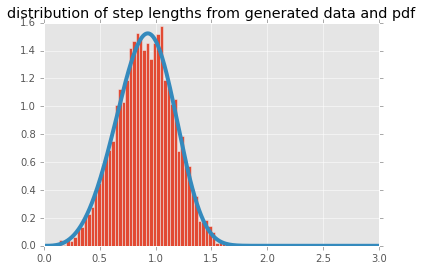

In [112]:
# calculate the log likelihood of weibull(a,b)
import scipy.stats 
from scipy.stats import dweibull
import numpy as np
from numpy import prod

def weib(x,scale,shape):
    return (shape / scale) * (x )**(shape - 1) * np.exp(-((x )**shape)/scale)
def logweib(x,scale,shape):
    return np.sum(np.log((shape / scale) * (x )**(shape - 1) * np.exp(-((x )**shape)/scale)))

plt.hist(data,bins=50,normed=True)
x=np.arange(0,3,0.01)
plt.plot(x,weib(x,alpha,beta),lw=4)
plt.title('distribution of step lengths from generated data and pdf')
plt.show()

In [108]:
import scipy.stats as stats
from scipy.stats import invgamma

#prior parameters
ap=1
bp=1

# initial guess for theta(a and b) as array. Now the shape 2 is fixed, the prior is inverse gamma(1,2)
guess = 2# initial guess for scale
# Prepare storing MCMC chain as array of arrays.
A = [guess]
# define stepsize of MCMC.
stepsizes = 0.04 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = logweib(data,old_theta,beta)#calculate the first log likelihood
old_logtarget=old_loglik+invgamma.logpdf(old_theta,bp,scale=ap)
# Metropolis-Hastings with 10,000 iterations.
for p in range(10000):
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta<0: 
        continue
    new_loglik = logweib(data,new_theta,beta)
    new_logtarget=new_loglik+invgamma.logpdf(new_theta,bp,scale=ap)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_logtarget > old_logtarget):
        A.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
        old_logtarget=new_logtarget
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_logtarget-old_logtarget)):
            A.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
            old_logtarget=new_logtarget 
        else:
            A.append(old_theta)
        
print("Acceptance rate = "+str(accepted/10000.0))



Acceptance rate = 0.3956


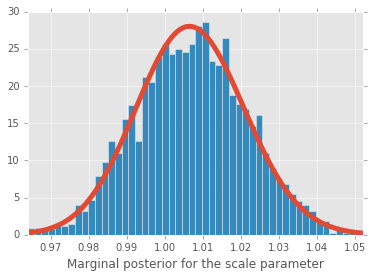

In [113]:
a = bp+n
b=ap+sum(data**beta)
x = np.linspace(invgamma.ppf(0.001,a,scale=b),invgamma.ppf(0.999, a,scale=b),100)
plt.plot(x,invgamma.pdf(x,a,scale=b),'-',lw=5)
plt.hist(A,bins=50,range=[np.min(x),np.max(x)],normed=True)
plt.xlabel("Marginal posterior for the scale parameter")
plt.xlim([np.min(x),np.max(x)])
plt.show()

